In [48]:
import implicit
import pandas as pd
import numpy as np
import scipy.sparse as sp
import os
from pathlib import Path
from catboost import cv, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap
import collections
from gensim.models import Word2Vec
from sklearn.metrics import roc_auc_score

In [49]:
dir_name = Path('/mnt') / 'sda3' / 'roman'/ 'Documents' / 'hw2'

In [50]:
train = pd.read_csv(dir_name / 'train.csv')
members = pd.read_csv(dir_name / 'members.csv')
songs = pd.read_csv(dir_name / 'songs.csv')
song_extra_info = pd.read_csv(dir_name / 'song_extra_info.csv')

In [51]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [52]:
def nan_counter(data):
    for i in data.columns:
        print(f'{i}: {data[i].isna().sum() / len(data[i])}')

In [53]:
def fill_nan_with_mode(data, names):
    for name in names:
        data[name] = data[name].fillna(data[name]
                                       .value_counts().argmax())

In [54]:
def raplace_nan_unknow(data, names):
    for name in names:
        data[name] = data[name].fillna('<?>')

In [55]:
nan_counter(train)

msno: 0.0
song_id: 0.0
source_system_tab: 0.0033682516023898876
source_screen_name: 0.05622617560778039
source_type: 0.0029195851448298037
target: 0.0


In [56]:
fill_nan_with_mode(train, ['source_system_tab', 
                           'source_screen_name',
                          'source_type'])

In [57]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [58]:
nan_counter(members)

msno: 0.0
city: 0.0
bd: 0.0
gender: 0.5784960613899951
registered_via: 0.0
registration_init_time: 0.0
expiration_date: 0.0


In [59]:
raplace_nan_unknow(members, ['gender'])

In [60]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [61]:
nan_counter(songs)

song_id: 0.0
song_length: 0.0
genre_ids: 0.04098557692307692
artist_name: 0.0
composer: 0.4665525710702341
lyricist: 0.8471240942028986
language: 4.35479375696767e-07


In [62]:
def add_splitted(in_val):
    in_val = str(in_val)
    if in_val != 'nan':
        return list(map(int, in_val.split("|")))
    else:
        return []

genre_list = songs.genre_ids.apply(add_splitted)

In [63]:
genre_set = set()

def add_to_set(value):
    for i in value:
        genre_set.add(i)

genre_list.apply(add_to_set)
len(genre_set)

191

In [64]:
genre_representative_set = set()
min_count = 10000
for i in genre_set:
    transformed = genre_list.apply(lambda x: int(i in x))
    if transformed.sum() > min_count:
        songs["genre_" + str(i)] = transformed
        genre_representative_set.add(i)

songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,genre_2058,genre_1572,genre_2086,...,genre_940,genre_947,genre_437,genre_444,genre_958,genre_451,genre_458,genre_465,genre_2022,genre_1011
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
songs.drop(['genre_ids', 'lyricist', 'composer'], axis=1, inplace=True)

In [66]:
song_extra_info.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [67]:
nan_counter(song_extra_info)

song_id: 0.0
name: 8.710911418306242e-07
isrc: 0.05947287661734403


In [68]:
def to_year(date):
    if type(date) == str:
        return int(date[5:7])
    else:
        return 1980
    
song_extra_info['song_year'] = song_extra_info['isrc'].apply(to_year)
song_extra_info.drop(['isrc'], axis = 1, inplace = True)

In [69]:
song_extra_info.drop(['name'], axis = 1, inplace = True)

In [70]:
train = train.merge(members, on="msno", how='left')
train = train.merge(songs, on="song_id", how='left')
train = train.merge(song_extra_info, on="song_id", how='left')

In [71]:
len(train)

7377418

In [72]:
def nan_final_replacer(df):
    for i in df.select_dtypes(include=['object']).columns:
        df[i].fillna('<?>')
    df = df.fillna(0)
    return df

In [73]:
train = nan_final_replacer(train)

In [74]:
def remake_type(data):
    data.city = data.city.astype(str).astype('category')
    data.song_id = data.song_id.astype(str).astype('category')
    data.language = data.language.astype(int).astype('category')
    data.song_year = data.song_year.astype(int)
    for i in genre_representative_set:
        data["genre_" + str(i)] = data["genre_" + str(i)].astype(int).astype('category')
    return data

In [75]:
train = remake_type(train)

In [76]:
label = train['target']
train.drop('target', axis = 1, inplace = True)
cat_boost_train = train

In [77]:
categorial = set(range(52))
categorial.remove(6)
categorial.remove(9)
categorial.remove(10)
categorial.remove(11)
categorial.remove(51)
categorial = list(categorial)

# CatBoost

In [119]:
train_pool = Pool(data=train, label=label, cat_features=categorial, has_header=True)

In [34]:
model = CatBoostRegressor(task_type='CPU', 
                          loss_function='RMSE', iterations=100)

In [37]:
param_grid = {
    'learning_rate': [0.4, 0.3, 0.25],
    'depth':[14, 15, 16],
    'l2_leaf_reg': [0.5, 1, 1.5]
}

In [ ]:
grid_search_results = model.grid_search(param_grid,
            train_pool,
            cv=5,
            search_by_train_test_split=True,
            refit=True,
            shuffle=True,
            train_size=0.8,
            verbose=True,
            plot=True)

In [39]:
grid_search_results['params']

{'depth': 15, 'l2_leaf_reg': 1, 'learning_rate': 0.3}

In [35]:
params = {
    'depth': 15,
    'l2_leaf_reg': 1,
    'learning_rate': 0.3,
    'loss_function': 'RMSE',
    'iterations': 100,
    'custom_loss': 'AUC'
}

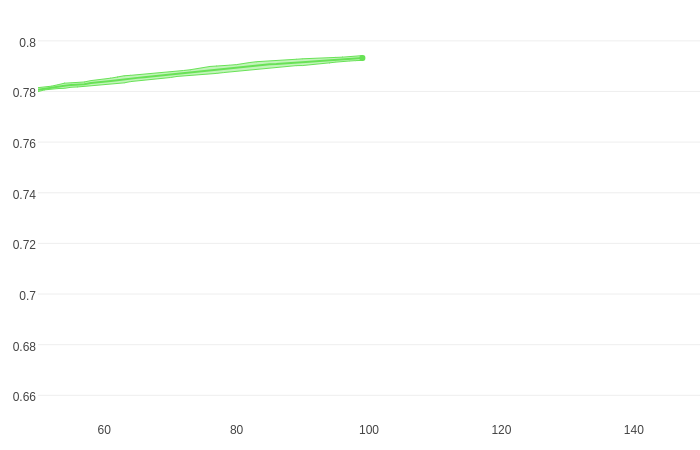

In [38]:
cv_results = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
)

In [45]:
last = cv_results.iloc[-1]
print(f"AUC: {last['test-AUC-mean']:.3f}")

AUC: 0.793


# Shap

In [120]:
model = CatBoostRegressor(loss_function='RMSE', iterations=100,
    depth=15, l2_leaf_reg=1, learning_rate=0.3)

In [ ]:
model.fit(train_pool)

In [122]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(train.iloc[:5000])

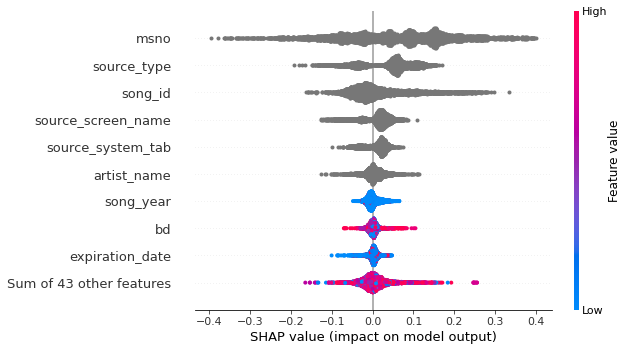

In [123]:
#Видно, что msno сильно влияет на результат, а значит лес пытается учить историю прослушиваний
shap.plots.beeswarm(shap_values)

# W2V

In [31]:
#Обрежем датасет, так как учится довольно долго
train = pd.read_csv(dir_name / 'train.csv').iloc[:1000000]
songs = pd.read_csv(dir_name / 'songs.csv')

In [32]:
train, test = train_test_split(train, train_size = 0.8)

In [33]:
positive = train[train['target'] == 1]
label = train['target']
users = np.unique(positive['msno'].values)
users_listened = [list(positive[positive['msno'] == i]['song_id'].astype(str)) for i in users]

In [34]:
vector_size=128
model = Word2Vec(window=12, vector_size=vector_size)
model.build_vocab(users_listened, progress_per=100)

In [35]:
model.train(users_listened, total_examples=model.corpus_count, epochs=50)

(22887787, 27668050)

In [36]:
def make_embedding_of_user(w2v, X, Y):
    counter_of_user = collections.defaultdict(int)
    embedding_of_user = collections.defaultdict(lambda: np.zeros((vector_size)))
    for (_, r), y in zip(X.iterrows(), Y):
        if y > 0.0:
            j = r['song_id']
            if j in w2v:
                i = r['msno']
                embedding_of_user[i] += w2v[j]
                counter_of_user[i] += 1
    for i in embedding_of_user.keys():
        embedding_of_user[i] /= counter_of_user[i]
    return embedding_of_user

user_vectors = make_embedding_of_user(model.wv, positive, label)

In [37]:
def calc_result(w2v, X, embedding_of_user):
    
    def get_prob(x):
        u = x['msno']
        i = x['song_id']
        user_embedding = embedding_of_user[u]
        song_embedding = w2v[i] if i in w2v else np.zeros(vector_size)
        eps = 10e-6
        return np.dot(user_embedding / (np.linalg.norm(user_embedding) + eps), song_embedding / (np.linalg.norm(song_embedding) + eps))
    
    return X.apply(lambda x: get_prob(x), axis=1)

In [17]:
results_test = calc_result(model.wv, test, user_vectors)

In [18]:
# Так как мы использовали только часть датасета, однако уже из этого следует что можно получить лечший результат,
# если их совместить с бустингом
roc_auc_score(test['target'], results_test)

0.623518773922426

# Similars

In [41]:
def get_similars(item_name, number=10):
    near = model.wv.most_similar(item_name, topn=number)
    list_of_results = []
    for song_id, similarity in near:
        result = songs[songs['song_id'] == song_id].to_dict('records')[0]
        result['similarity'] = similarity
        list_of_results.append(result)        
    return pd.DataFrame(list_of_results)
#Заметим, что все песни примерно одного жанра, что отлично
get_similars(list(model.wv.index_to_key)[7])

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,similarity
0,ISZdpC3A/+xvUw0I6Kw0z03/kaK3AmnqV9FU2p9M8NU=,241162,465,梁靜茹 (Fish Leong),NaN,NaN,3.0,0.261999
1,YBrWf/Hac5La5V2HZ80Mi70NzUcTehVDWhkIp8h4Klg=,266135,458,蔡依林 (Jolin Tsai),Huang-Zhong-Ren| Jay Chou,Wen-Shan Fang,3.0,0.251724
2,nt+hY8boPKCRNeo7Oha7roBlTsJMhStJvKL2jJ4DPEo=,239281,465,畢書盡 (Bii),畢書盡+天才,天才,3.0,0.249832
3,hORLeB0U2xr/YnLWF+XGRf8Pdrn6Nvebv2FREUrO/HI=,285884,465,曾昱嘉,NaN,NaN,3.0,0.240181
4,MWABo6OeSqc3stilsIyqU/c8texhFf8BfWGRMN5LUaI=,295706,458,A-Lin,李榮浩,姚若龍,3.0,0.238638
5,vILy7KQyFxIPbaIm5J2mCTEHvMr3/7H7Hl9trGrL+7c=,243356,465,李聖傑 (Sam Lee),NaN,NaN,3.0,0.235676
6,WrVBxKvotVYzAKxCxNAGssQ1oCgO0gAJ4sNCfhfdfOY=,198426,465,Under Lover (地下情人),楊琳,楊琳,3.0,0.231018
7,u4Q31WoUXsQHIRRr1mbgUxXyauv1wfaCzPte/fFqmdo=,231105,465,林俊傑 (JJ Lin),JJ Lin,Lin Yi Feng,3.0,0.229557
8,GhRkAipXLrIkEoUMQxUm8+0d6fcNj6yPMwqgcrKi4Uk=,208143,458,楊丞琳 (Rainie Yang),Zhi Wen Du,NaN,3.0,0.226060
9,243h5va0u/z+CK6rSDXNSn9C+Vpy1O6yBy4R5n/CI7A=,255895,465,鄭欣宜 (Joyce Cheng),藍奕邦,黃偉文,24.0,0.225873


# W2V + CatBoost

In [78]:
sim_train = calc_result(model.wv, cat_boost_train, user_vectors)

In [79]:
cat_boost_train["z_sim"] = sim_train

In [82]:
train_pool = Pool(data=cat_boost_train, label=label, cat_features=categorial, has_header=True)

In [83]:
params = {
    'depth': 15,
    'l2_leaf_reg': 1,
    'learning_rate': 0.3,
    'loss_function': 'RMSE',
    'iterations': 100,
    'custom_loss': 'AUC'
}

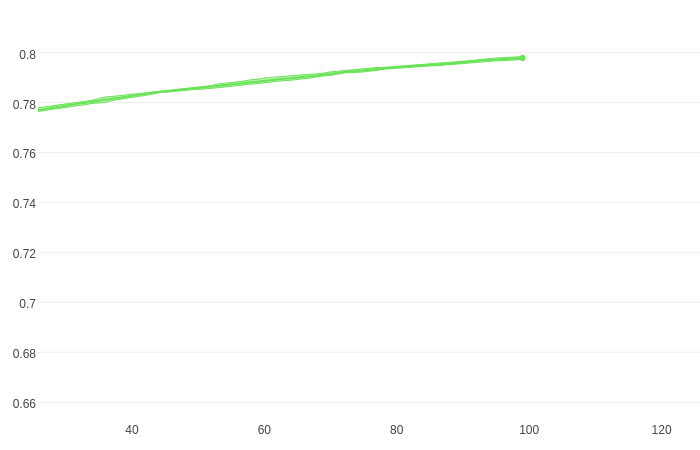

In [85]:
cv_results = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
)

In [82]:
last = cv_results.iloc[-1]
print(f"AUC: {last['test-AUC-mean']:.3f}")

AUC: 0.798


In [83]:
#Скорей всего столь небольшой рост вызван тем, что я подаю для обучения w2v только часть данных

In [ ]:
#Однако само его наличие говорит о существенности фичи скалярного произведения

# Shap W2V + CatBoost

In [84]:
model = CatBoostRegressor(loss_function='RMSE', iterations=100,
    depth=15, l2_leaf_reg=1, learning_rate=0.3)

In [ ]:
model.fit(train_pool)

In [86]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(cat_boost_train.iloc[:5000])

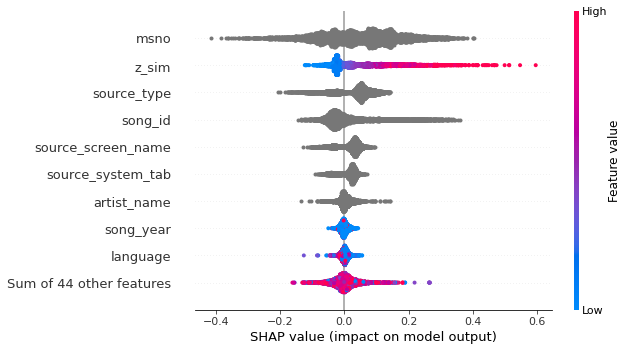

In [87]:
shap.plots.beeswarm(shap_values)

In [89]:
# Видно, что добавленный нами признак оказался 2ым по важности, однако не заменил полностью msno.
# Видимо вызвано это неполным датасетом для обучения w2v